In [39]:
# Cell 1 — imports + helpers (Polars)
import polars as pl
import numpy as np
import re
# Visualization of the dataframe
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scripts import style
style.mpl_apply()

In [40]:
path = "data/processed/Canada Vigilance Adverse Reaction Online Database/"
# pair_ohe = pl.read_parquet(path + "pair_ohe_full.parquet")

In [41]:
merge = pl.read_parquet(path + "merge_clean_df.parquet")

In [42]:
SAFE_CHARS = re.compile(r"[^A-Za-z0-9_]+")

def safe_col(prefix: str, s: str) -> str:
    if s is None:
        return f"{prefix}__UNK"
    s = str(s).strip()
    s = SAFE_CHARS.sub("_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return f"{prefix}__{s}" if s else f"{prefix}__UNK"

def report_ohe(df: pl.DataFrame, key: str, catcol: str, prefix: str) -> pl.DataFrame:
    """
    One-hot at REPORT level in Polars: 1 if category appears at least once in the report.
    Returns a DataFrame with `key` plus OHE columns prefixed by `prefix__`.
    """
    sub = (
        df.select([pl.col(key), pl.col(catcol)])
          .drop_nulls()
          .unique()
          .with_columns(pl.lit(1).alias("_one"))
    )
    if sub.height == 0:
        return df.select(pl.col(key)).unique()
    piv = sub.pivot(values="_one", index=key, columns=catcol, aggregate_function="max").fill_null(0)
    # sanitize column names and cast to UInt8
    rename_map = {c: safe_col(prefix, c) for c in piv.columns if c != key}
    piv = piv.rename(rename_map)
    ohe_cols = [c for c in piv.columns if c != key]
    piv = piv.with_columns([pl.col(ohe_cols).cast(pl.UInt8)])
    return piv


def report_ohe2(df: pl.DataFrame, key: str, catcol: str, prefix: str) -> pl.DataFrame:
    """
    One-hot at REPORT level in Polars: 1 if category appears at least once in the report.
    Returns a DataFrame with `key` plus OHE columns prefixed by `prefix__`.
    """
    sub = (
        df.select([pl.col(key), pl.col(catcol)])
        .drop_nulls()
        .unique()
        .with_columns(pl.lit(1).alias("_one"))
    )

    if sub.height == 0:
        return df.select(pl.col(key)).unique()

    piv = sub.pivot(values="_one", index=key, columns=catcol, aggregate_function="max").fill_null(0)
    # sanitize column names and cast to UInt8
    rename_map = {c: safe_col(prefix, c) for c in piv.columns if c != key}

    # Handle potential duplicate sanitized names by appending a counter
    used_names = set()
    for old, new in rename_map.items():
        if new in used_names:
            counter = 1
            while f"{new}_{counter}" in used_names:
                counter += 1
            rename_map[old] = f"{new}_{counter}"
        used_names.add(rename_map[old])
    piv = piv.rename(rename_map)
    ohe_cols = [c for c in piv.columns if c != key]
    piv = piv.with_columns([pl.col(ohe_cols).cast(pl.UInt8)])
    return piv


In [43]:
# Cell 2 — validate columns + strip whitespace (Polars)
required = {"REPORT_ID","ACTIVE_INGREDIENT_NAME","PT_NAME_ENG","SOC_NAME_ENG","INDICATION_NAME_ENG"}
missing = required - set(merge.columns)
if missing:
    raise KeyError(f"Missing columns in `merge`: {sorted(missing)}")

text_cols = ["ACTIVE_INGREDIENT_NAME","PT_NAME_ENG","SOC_NAME_ENG","INDICATION_NAME_ENG"]
merge = merge.with_columns([pl.col(c).cast(pl.Utf8).str.strip_chars().alias(c) for c in text_cols])

In [44]:
# Cell 3 — build (REPORT_ID, ACTIVE_INGREDIENT_NAME) pairs + line counts
pair = (
    merge.select(["REPORT_ID","ACTIVE_INGREDIENT_NAME"])
         .drop_nulls()
         .unique()
)

pair_counts = (
    merge.group_by(["REPORT_ID","ACTIVE_INGREDIENT_NAME"])
         .len()
         .rename({"len":"line_count"})
)

pair = pair.join(pair_counts, on=["REPORT_ID","ACTIVE_INGREDIENT_NAME"], how="left")
pair.head()


REPORT_ID,ACTIVE_INGREDIENT_NAME,line_count
i64,str,u32
904110948,"""ceftriaxone, sodium, sesquater…",288
902501456,"""ceftazidime""",3
905322714,"""cefixime trihydrate""",105
901293048,"""ceftaroline fosamil""",1512
901135156,"""cefazolin""",2


In [45]:
# Cell 4 — report-level OHE blocks for PT, SOC, IND
pt  = report_ohe(merge, key="REPORT_ID", catcol="PT_NAME_ENG",  prefix="PT")
soc = report_ohe(merge, key="REPORT_ID", catcol="SOC_NAME_ENG", prefix="SOC")
ind = report_ohe(merge, key="REPORT_ID", catcol="INDICATION_NAME_ENG", prefix="IND")
ing = report_ohe2(merge, key="REPORT_ID", catcol="ACTIVE_INGREDIENT_NAME", prefix="ING")

C:\Users\herie\AppData\Local\Temp\ipykernel_45032\4120972277.py:24: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  piv = sub.pivot(values="_one", index=key, columns=catcol, aggregate_function="max").fill_null(0)
C:\Users\herie\AppData\Local\Temp\ipykernel_45032\4120972277.py:48: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  piv = sub.pivot(values="_one", index=key, columns=catcol, aggregate_function="max").fill_null(0)


In [46]:


# # union of all REPORT_ID present in any block
# report_ids = (
#     pl.concat([pt.select("REPORT_ID"),
#                soc.select("REPORT_ID"),
#                ind.select("REPORT_ID")], how="diagonal")
#       .unique()
# )

# # bring all OHEs to a common set of REPORT_IDs
# ohe = (
#     report_ids
#     .join(pt,  on="REPORT_ID", how="left")
#     .join(soc, on="REPORT_ID", how="left")
#     .join(ind, on="REPORT_ID", how="left")
#     .join(ing, on="REPORT_ID", how="left")
# )

# # fill missing OHEs with 0 and cast to UInt8
# ohe_cols = [c for c in ohe.columns if c.startswith(("PT__","SOC__","IND__","ING__"))]
# ohe = ohe.with_columns([pl.col(ohe_cols).fill_null(0).cast(pl.UInt8)])
# ohe.shape, len(ohe_cols)




In [47]:
# # Cell 7 — sanity checks
# # 1) no duplicates for the conjunction
# dup_count = (
#     pair_ohe.select(["REPORT_ID","ACTIVE_INGREDIENT_NAME"])
#             .with_columns(pl.lit(1).alias("_one"))
#             .group_by(["REPORT_ID","ACTIVE_INGREDIENT_NAME"])
#             .agg(pl.sum("_one").alias("n"))
#             .filter(pl.col("n") > 1)
#             .height
# )
# print("Duplicates (should be 0):", dup_count)

# # 2) fraction of pairs with at least one PT flag
# pt_cols = [c for c in ohe_cols if c.startswith("PT__")]
# frac_with_pt = (
#     pair_ohe.select((pl.sum_horizontal([pl.col(c) for c in pt_cols]) > 0).alias("has_pt"))
#             .select(pl.mean("has_pt"))
#             .item()
# )
# print(f"Pairs with ≥1 PT flag: {frac_with_pt:.3f}")
# # if pairs with no PT flags > 0.1, warn
# if frac_with_pt < 0.9:
#     print("WARNING: More than 10% of pairs have no PT flags!")
# else:
#     print(f"Sanity checks passed, {frac_with_pt:.3f} pairs have PT flags, proceeding.")


# # Cell 8 — save to disk (optional)
# path = "data/processed/Canada Vigilance Adverse Reaction Online Database/"
# pair_ohe.write_parquet(path + "pair_ohe_full.parquet")

# OHES

In [49]:
soc_cols = soc.columns
# sort and replace _ with space
soc_cols = [c.replace("SOC__", "").replace("_", " ") for c in soc_cols]
# rename the cols in the dataframe
soc = soc.rename({old: new for old, new in zip(soc.columns, soc_cols)})

output_path = "data/processed"
soc.write_parquet(output_path + "/soc_ohe.parquet")
soc

REPORT ID,Gastrointestinal disorders,Infections and infestations,Investigations,Musculoskeletal and connective tissue disorders,Immune system disorders,Renal and urinary disorders,Injury poisoning and procedural complications,Respiratory thoracic and mediastinal disorders,Pregnancy puerperium and perinatal conditions,General disorders and administration site conditions,Skin and subcutaneous tissue disorders,Cardiac disorders,Surgical and medical procedures,Blood and lymphatic system disorders,Vascular disorders,Metabolism and nutrition disorders,Neoplasms benign malignant and unspecified incl cysts and polyps,Endocrine disorders,Nervous system disorders,Eye disorders,Product issues,Psychiatric disorders,Ear and labyrinth disorders,Hepatobiliary disorders,Social circumstances,Congenital familial and genetic disorders,Reproductive system and breast disorders,UNK
i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
905006504,1,1,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0
903034107,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
907420131,1,1,1,0,0,1,0,0,0,1,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
915771,1,1,1,1,0,1,1,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
902082667,1,0,1,1,1,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1058919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
905749760,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1071634,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
pt_cols = pt.columns
# sort and replace _ with space
pt_cols = [c.replace("PT__", "").replace("_", " ") for c in pt_cols]
# rename the cols in the dataframe
pt = pt.rename({old: new for old, new in zip(pt.columns, pt_cols)})
pt.write_parquet(output_path + "/pt_ohe.parquet")
pt

REPORT ID,Drug hypersensitivity,Paraesthesia,Malaise,Sepsis,Death,Clostridium difficile infection,Granulomatosis with polyangiitis,Pain management,Wheezing,Bacterial infection,Pseudomonal bacteraemia,Arteriosclerosis coronary artery,Anuria,Cellulitis,Asthenia,Thrombocytopenic purpura,Urticaria,Platelet count increased,Abdominal discomfort,Rotator cuff syndrome,Second primary malignancy,Oral pruritus,Cerebrovascular disorder,Vomiting,Asthma,Dizziness,Off label use,Chills,Joint stiffness,Acute kidney injury,Pulmonary mass,Drug interaction,Intentional product misuse,Heart rate increased,Aplastic anaemia,General physical health deterioration,…,Stasis dermatitis,Dysmorphism,Pulmonary resection,Transferrin decreased,Tracheal stenosis,Lymphocyte percentage abnormal,Myoglobin urine present,Coeliac disease,Cutaneous calcification,Pustular psoriasis,Dose calculation error,Blood sodium abnormal,Posturing,Renal aneurysm,Pharyngo oesophageal diverticulum,Delusion of parasitosis,Pulmonary sepsis,Paresis,Renal hypoplasia,Idiopathic angioedema,Conjunctival erosion,Perinatal depression,Apathy,Acute myeloid leukaemia refractory,Sinus headache,Drug chemical incompatibility,Tendon discomfort,Drug tolerance,Gastric antral vascular ectasia,Implant site inflammation,Listeriosis,Increased dose administered,Orchitis,Fontanelle bulging,Oral mucosal erythema,Lupus vulgaris,Wound treatment
i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
906581402,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
902642693,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
907179064,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
903491996,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
906573410,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
901566024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1013510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
678747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
ing_cols = ing.columns
# sort and replace _ with space
ing_cols = [c.replace("ING__", "").replace("_", " ") for c in ing_cols]
# rename the cols in the dataframe
ing = ing.rename({old: new for old, new in zip(ing.columns, ing_cols)})
ing.write_parquet(output_path + "/activeingredient_ohe.parquet")
ing

REPORT ID,cefixima,ceftriaxone sodique,ceftriaxone,ceftriaxone disodium,cefazolin,cefadroxil,cephazolin sodium,cefodizime sodium,ceftriaxone sodium sesquaterhydrate,cefprozil,cefotaxime,ceftriaxone sodium,sodium cefazolin,cefuroxime salt not specified,cefuroxime,cefixime trihydrate,sodium ceftriaxone,ceftriaxone sodium hydrate,cefixime,cefazolin sodium,cefalexin,ceftazidime,cefazoline benzathine,cefazolin sodium 1,cefaclor,cefuroxime sodium,cefotaxime sodium,ceftriaxone sodium sesquaterhydrate 1,cefazolin benzathine,cefaclor monohydrate,ceftaroline,cefoxitin,cefatrizine,cefuroxime axetil,cefcapene pivoxil hydrochloride,ceftazidime pentahydrate,…,cefcapene pivoxil hydrochloride hydrate,cefcapene pivoxil,cefotaxime sodique,cefepime dihydrochloride monohydrate,ceftaroline fosamil,sodium ceforoxine,sodium cefoxitin,cefepim,cefprozil monohydrate,cefepime,ceftobiprole,cefdinir,cefadroxil monohydrate,cefpodoxime proxetil,cefepime hydrochloride,ceftaroline fosamil acetate,cefcapene pivoxil hcl,cefepime hydrochloride monohydrate,cephalexin,ceftolozane sulfate,cefalexin sodium,cefoxitin sodium,cefodizime,cefepime hcl,cefoperazone sodium,cefotiam hexetil hydrochloride,probenecid,methylol cefalexin lysinate,tazobactam,cefepime hydrochloride monohydrate 1,ceftolozane,cefotiam,cefmetazole sodium,cefotiam hydrochloride,cefodizime disodium,tazobactam sodium,tazobactam sodique
i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
907457231,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
908134609,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1091771,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
900783483,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
902429173,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
667767,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
470724,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
684713,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
ind_cols = ind.columns
# sort and replace _ with space
ind_cols = [c.replace("IND__", "").replace("_", " ") for c in ind_cols]
# rename the cols in the dataframe
ind = ind.rename({old: new for old, new in zip(ind.columns, ind_cols)})
ind.write_parquet(output_path + "/indication_ohe.parquet")
ind

REPORT ID,Rheumatoid arthritis,Muscle spasms,Sepsis,Sleep disorder therapy,Infection prophylaxis,Product used for unknown indication,Atrial fibrillation,Encephalitis,Infection,Pneumonia,Preterm premature rupture of membranes,Bacillus infection,Chronic obstructive pulmonary disease,Cellulitis,Gastrooesophageal reflux disease,Asthma,Osteoporosis,Iron deficiency,Immunosuppressant drug therapy,Sedative therapy,Chlamydial infection,Neuralgia,Enterovirus infection,Staphylococcal bacteraemia,Bone marrow transplant,Back pain,Stem cell transplant,Thrombosis,COVID 19 immunisation,Vitamin supplementation,Cardiogenic shock,Myalgia,Mineral supplementation,Influenza,Headache,Urinary tract infection,…,Cardiac amyloidosis,Ovarian epithelial cancer,Haemodialysis,Endoscopic retrograde cholangiopancreatography,Adenocarcinoma pancreas,Cataract,Ovarian epithelial cancer recurrent,Lung consolidation,Organ transplant,Hypoglycaemia,Blood osmolarity,Venoocclusive disease,Cardiac flutter,Cerebral venous thrombosis,Labour augmentation,Autonomic nervous system imbalance,Bruton s agammaglobulinaemia,Oesophagectomy,Croup infectious,Ventricular drainage,Splinter,Antiplatelet therapy,Restlessness,Mucopolysaccharidosis II,Parophthalmia,Influenza A virus test positive,Brain empyema,Erythrodermic atopic dermatitis,Febrile infection,Enema administration,Skin discolouration,Tongue oedema,Lactobacillus infection,Polyarteritis nodosa,Skin induration,Lung squamous cell carcinoma stage III,Pelvic abscess
i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
907553861,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
903707774,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1091784,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
905923043,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1144270,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1021150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
903068114,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998609,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Histograms

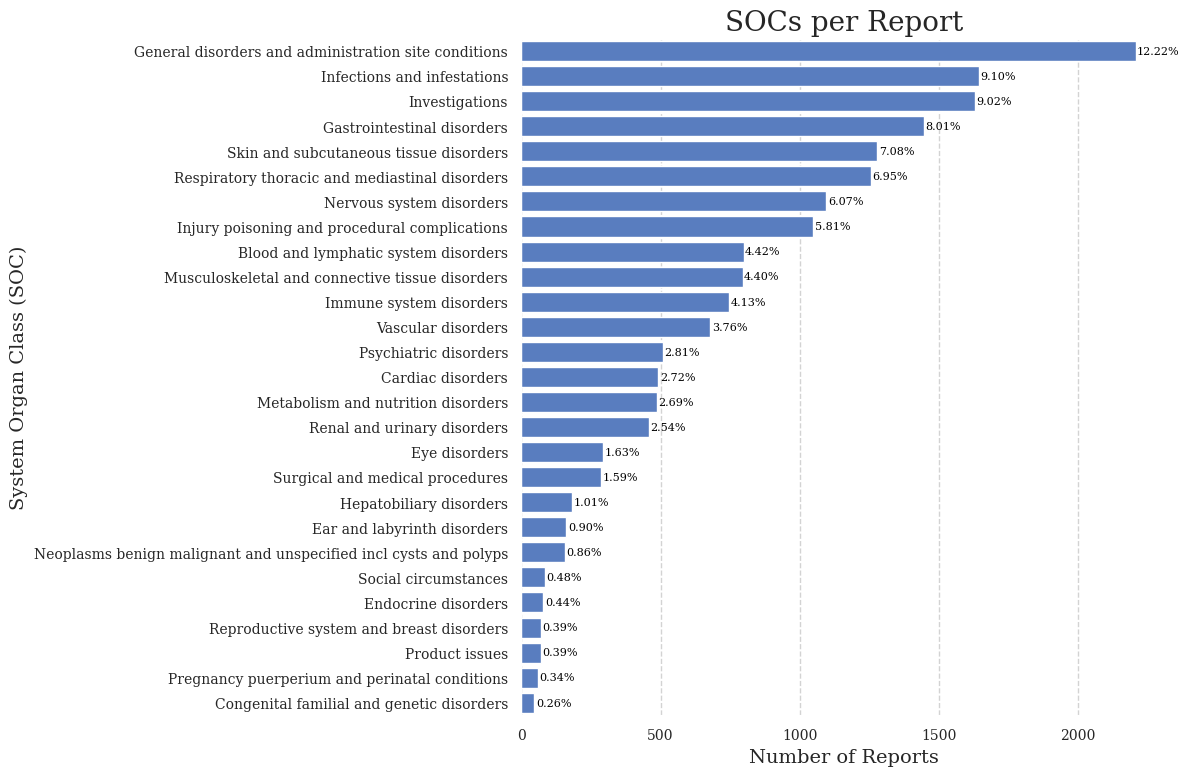

In [24]:
# plot the most common SOCs (System Organ Classes), TOP 50
soc_cols = [c for c in soc.columns]
# remove the REPORT_ID column
soc_cols.remove("REPORT ID")
soc_sums = soc.select([pl.col(c).sum().alias(c) for c in soc_cols]).to_dicts()[0]
soc_sums_sorted = dict(sorted(soc_sums.items(), key=lambda item: item[1], reverse=True)[:27])

plt.figure(figsize=(12, 8))
sns.barplot(x=list(soc_sums_sorted.values()), y=list(soc_sums_sorted.keys()))
plt.title("SOCs per Report") #  in Cephalosporin-related Adverse Drug Reactions
plt.xlabel("Number of Reports")
plt.ylabel("System Organ Class (SOC)")
# add percentages

total_reports = sum(soc_sums_sorted.values())
for i, v in enumerate(soc_sums_sorted.values()):
    percentage = (v / total_reports) * 100
    plt.text(v + 5, i, f"{percentage:.2f}%", color='black', va='center', size=8)
plt.savefig('visualizations/canada/00_01.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

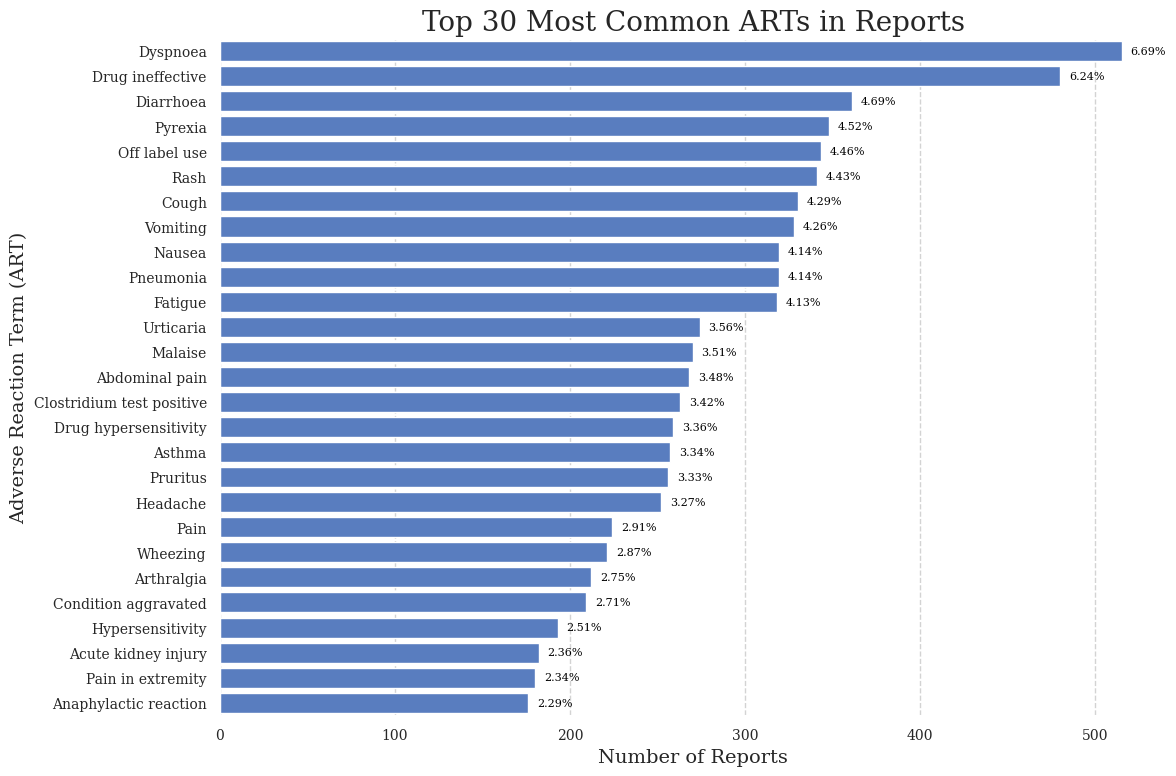

In [28]:
# plot the most common SOCs (System Organ Classes), TOP 50
pt_cols = [c for c in pt.columns]
# remove the REPORT_ID column
pt_cols.remove("REPORT ID")
pt_sums = pt.select([pl.col(c).sum().alias(c) for c in pt_cols]).to_dicts()[0]
pt_sums_sorted = dict(sorted(pt_sums.items(), key=lambda item: item[1], reverse=True)[:27])

plt.figure(figsize=(12, 8))
sns.barplot(x=list(pt_sums_sorted.values()), y=list(pt_sums_sorted.keys()))
plt.title("Top 30 Most Common ARTs in Reports")
plt.xlabel("Number of Reports")
plt.ylabel("Adverse Reaction Term (ART)")
# add percentages

total_reports = sum(pt_sums_sorted.values())
for i, v in enumerate(pt_sums_sorted.values()):
    percentage = (v / total_reports) * 100
    plt.text(v + 5, i, f"{percentage:.2f}%", color='black', va='center', size=8)
plt.savefig('visualizations/canada/00_02.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

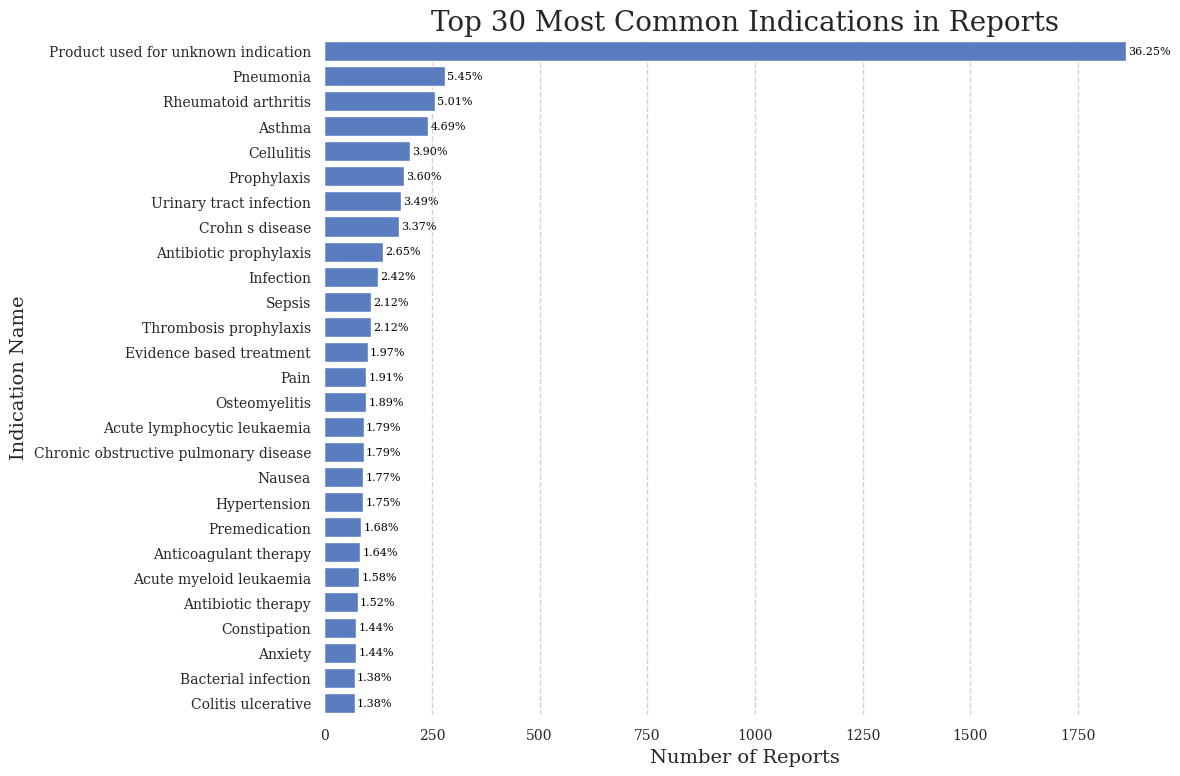

In [34]:
# plot the most common SOCs (System Organ Classes), TOP 50
ind_cols = [c for c in ind.columns]
# remove the REPORT_ID column
ind_cols.remove("REPORT ID")
ind_sums = ind.select([pl.col(c).sum().alias(c) for c in ind_cols]).to_dicts()[0]
ind_sums_sorted = dict(sorted(ind_sums.items(), key=lambda item: item[1], reverse=True)[:27])

plt.figure(figsize=(12, 8))
sns.barplot(x=list(ind_sums_sorted.values()), y=list(ind_sums_sorted.keys()))
plt.title("Top 30 Most Common Indications in Reports")
plt.xlabel("Number of Reports")
plt.ylabel("Indication Name")
# add percentages

total_reports = sum(ind_sums_sorted.values())
for i, v in enumerate(ind_sums_sorted.values()):
    percentage = (v / total_reports) * 100
    plt.text(v + 5, i, f"{percentage:.2f}%", color='black', va='center', size=8)
plt.savefig('visualizations/canada/00_03.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

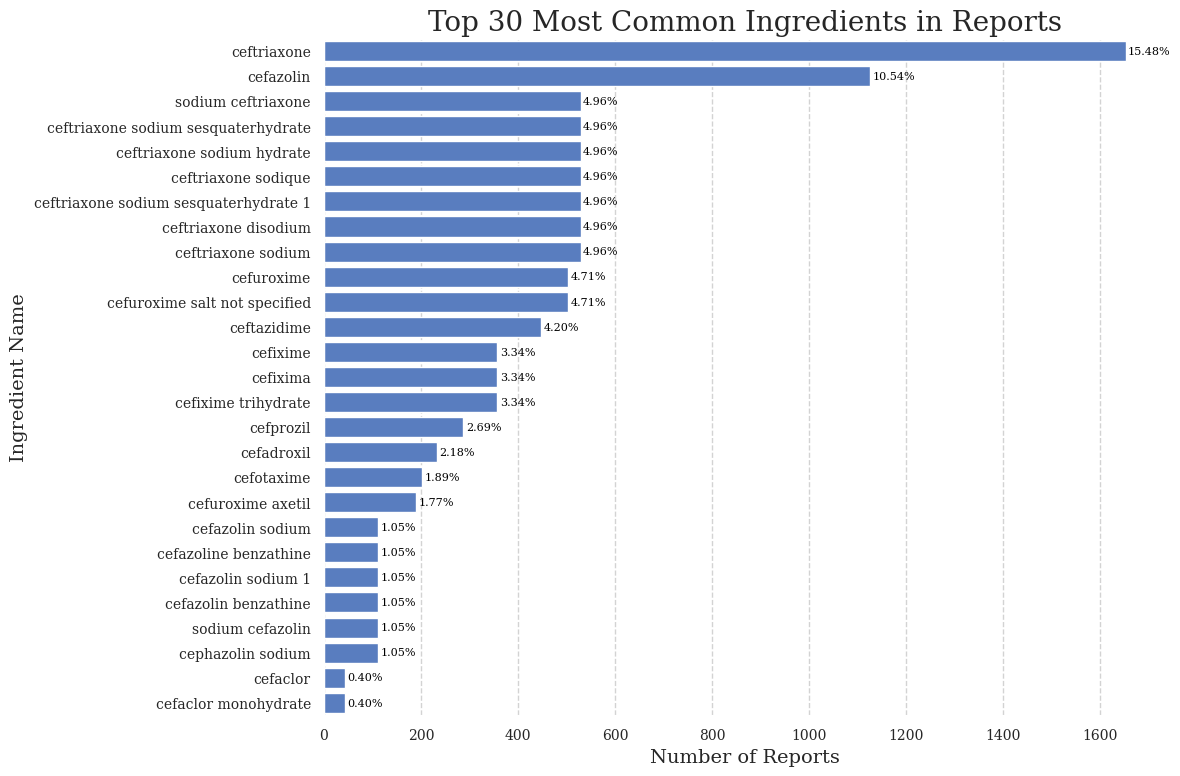

In [33]:
# plot the most common SOCs (System Organ Classes), TOP 50
ing_cols = [c for c in ing.columns]
# remove the REPORT_ID column
ing_cols.remove("REPORT ID")
ing_sums = ing.select([pl.col(c).sum().alias(c) for c in ing_cols]).to_dicts()[0]
ing_sums_sorted = dict(sorted(ing_sums.items(), key=lambda item: item[1], reverse=True)[:27])

plt.figure(figsize=(12, 8))
sns.barplot(x=list(ing_sums_sorted.values()), y=list(ing_sums_sorted.keys()))
plt.title("Top 30 Most Common Ingredients in Reports")
plt.xlabel("Number of Reports")
plt.ylabel("Ingredient Name")
# add percentages

total_reports = sum(ing_sums_sorted.values())
for i, v in enumerate(ing_sums_sorted.values()):
    percentage = (v / total_reports) * 100
    plt.text(v + 5, i, f"{percentage:.2f}%", color='black', va='center', size=8)
plt.savefig('visualizations/canada/00_04.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Correlations

## SOCS vs SOCS

In [20]:
pt

REPORT_ID,PT__Hypoxia,PT__Sinusitis,PT__Neuralgia,PT__Arthralgia,PT__Syncope,PT__Deafness,PT__Sputum_purulent,PT__Energy_increased,PT__Diabetes_mellitus,PT__Joint_swelling,PT__Dyspnoea,PT__Sleep_apnoea_syndrome,PT__Haemolysis,PT__Asthma,PT__Wheezing,PT__Blood_pressure_decreased,PT__Bone_erosion,PT__Discomfort,PT__Drug_intolerance,PT__Asthenia,PT__Upper_airway_cough_syndrome,PT__Death,PT__Pain,PT__Cystitis,PT__Device_leakage,PT__Arthropod_bite,PT__Angioedema,PT__Intestinal_operation,PT__Acute_kidney_injury,PT__Rash,PT__Female_genital_tract_fistula,PT__Hypersomnia,PT__Menstrual_disorder,PT__Suspected_product_contamination,PT__Vitamin_K_deficiency,PT__Hypoproteinaemia,…,PT__Salivary_gland_enlargement,PT__Portal_vein_flow_decreased,PT__Transfusion_associated_dyspnoea,PT__Micturition_frequency_decreased,PT__Meningitis_viral,PT__Sleeve_gastrectomy,PT__Conjunctivitis_viral,PT__Hepatic_pain,PT__Clostridial_infection,PT__Device_difficult_to_use,PT__Noninfective_encephalitis,PT__Drug_abuse,PT__Seroma,PT__Neonatal_tachypnoea,PT__Spontaneous_subdural_haematoma,PT__Anorectal_polyp,PT__Growth_retardation,PT__Fine_motor_skill_dysfunction,PT__Transplant_dysfunction,PT__Post_procedural_fistula,PT__Subcutaneous_haematoma,PT__Product_distribution_issue,PT__Debridement,PT__Nasal_dryness,PT__Cerebellar_haemorrhage,PT__Urostomy,PT__Hyperbilirubinaemia,PT__Lip_blister,PT__Sputum_retention,PT__Immune_mediated_lung_disease,PT__Gallbladder_operation,PT__Necrosis,PT__Inborn_error_of_metabolism,PT__Haemolytic_uraemic_syndrome,PT__Genital_haemorrhage,PT__Grandiosity,PT__Inadequate_analgesia
i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
1117137,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
900499680,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
906781412,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
903533754,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
902381672,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
988011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1042242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
907824937,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:

pair_ohe = pl.read_parquet(path + "pair_ohe_full.parquet")

# Get the one ones that has PT__ 
pts = [c for c in pair_ohe.columns if c.startswith("SOC__")]

# make it a dataframe with only REPORT_ID, ACTIVE_INGREDIENT_NAME, line_count and the pts columns
pt_df = pair_ohe.select(["REPORT_ID", "ACTIVE_INGREDIENT_NAME"] + pts)

# remove PT__ at the beginning of the column names
pt_df = pt_df.rename({c: c.replace("SOC__", "") for c in pts})

# drop ACTIVE_INGREDIENT_NAME
pt_df = pt_df.drop("ACTIVE_INGREDIENT_NAME")

event_cols = pt_df.columns[1:]  # Exclude REPORT_ID



# Update the column names in pt_df to reflect the replaced spaces
pt_df = pt_df.rename({c: c.replace("_", " ") for c in event_cols})

event_cols = pt_df.columns[1:]  # Exclude REPORT_ID

pt_df

REPORT_ID,Gastrointestinal disorders,Vascular disorders,Metabolism and nutrition disorders,Respiratory thoracic and mediastinal disorders,Investigations,Nervous system disorders,Infections and infestations,Cardiac disorders,General disorders and administration site conditions,Blood and lymphatic system disorders,Skin and subcutaneous tissue disorders,Hepatobiliary disorders,Endocrine disorders,Immune system disorders,Renal and urinary disorders,Product issues,Musculoskeletal and connective tissue disorders,Injury poisoning and procedural complications,Eye disorders,Pregnancy puerperium and perinatal conditions,Psychiatric disorders,Congenital familial and genetic disorders,Surgical and medical procedures,Social circumstances,Ear and labyrinth disorders,Reproductive system and breast disorders,UNK,Neoplasms benign malignant and unspecified incl cysts and polyps
i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
1041863,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
900005579,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1152741,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
901110428,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
903069933,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
903634817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
912201,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
334606,0,0,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0


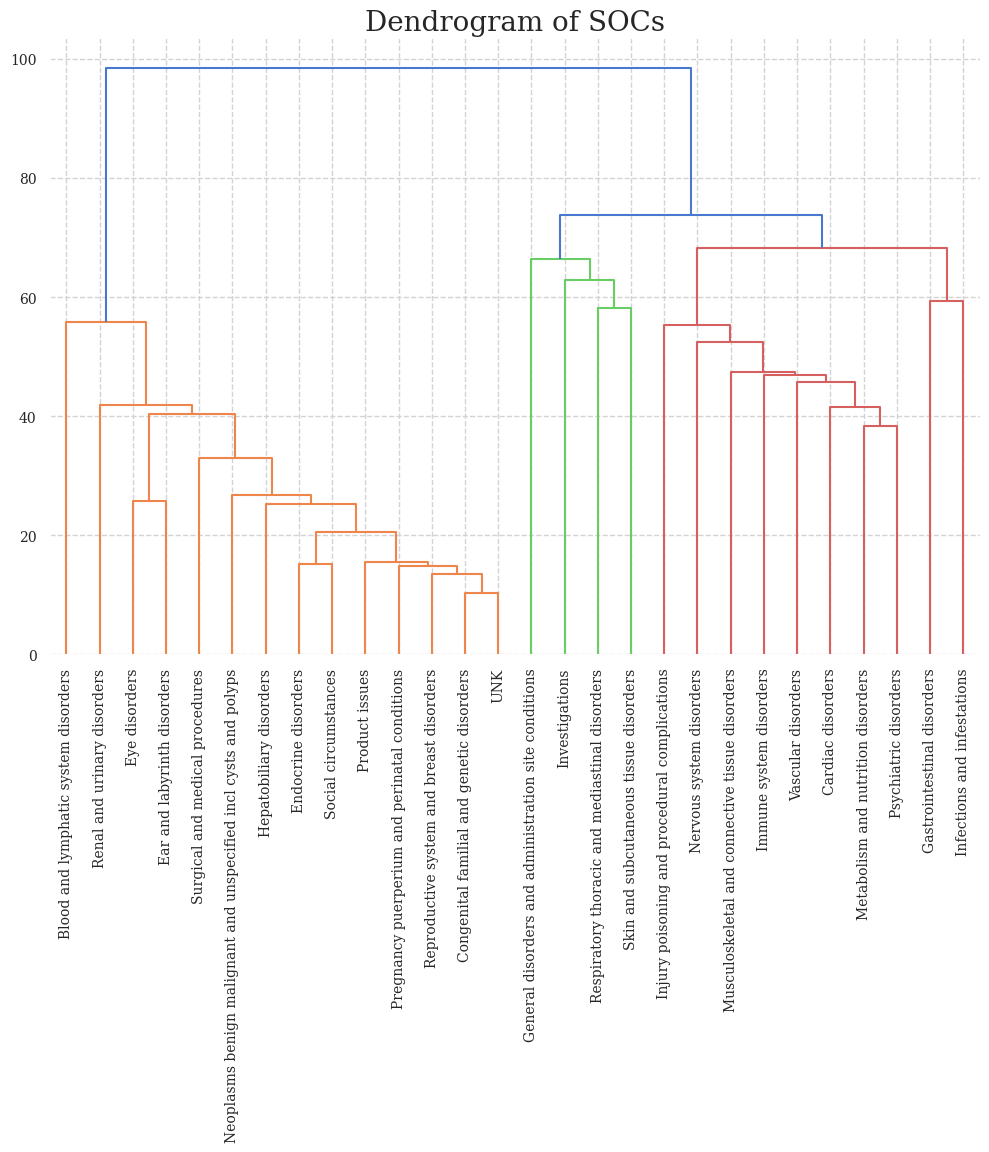

In [37]:
# plot dendogram of pt_df
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(pt_df.select(event_cols).to_pandas().T, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linked, labels=event_cols, leaf_rotation=90)
plt.title("Dendrogram of SOCs")
plt.savefig('visualizations/canada/soc_dendrogram.pdf', bbox_inches='tight')
plt.show()

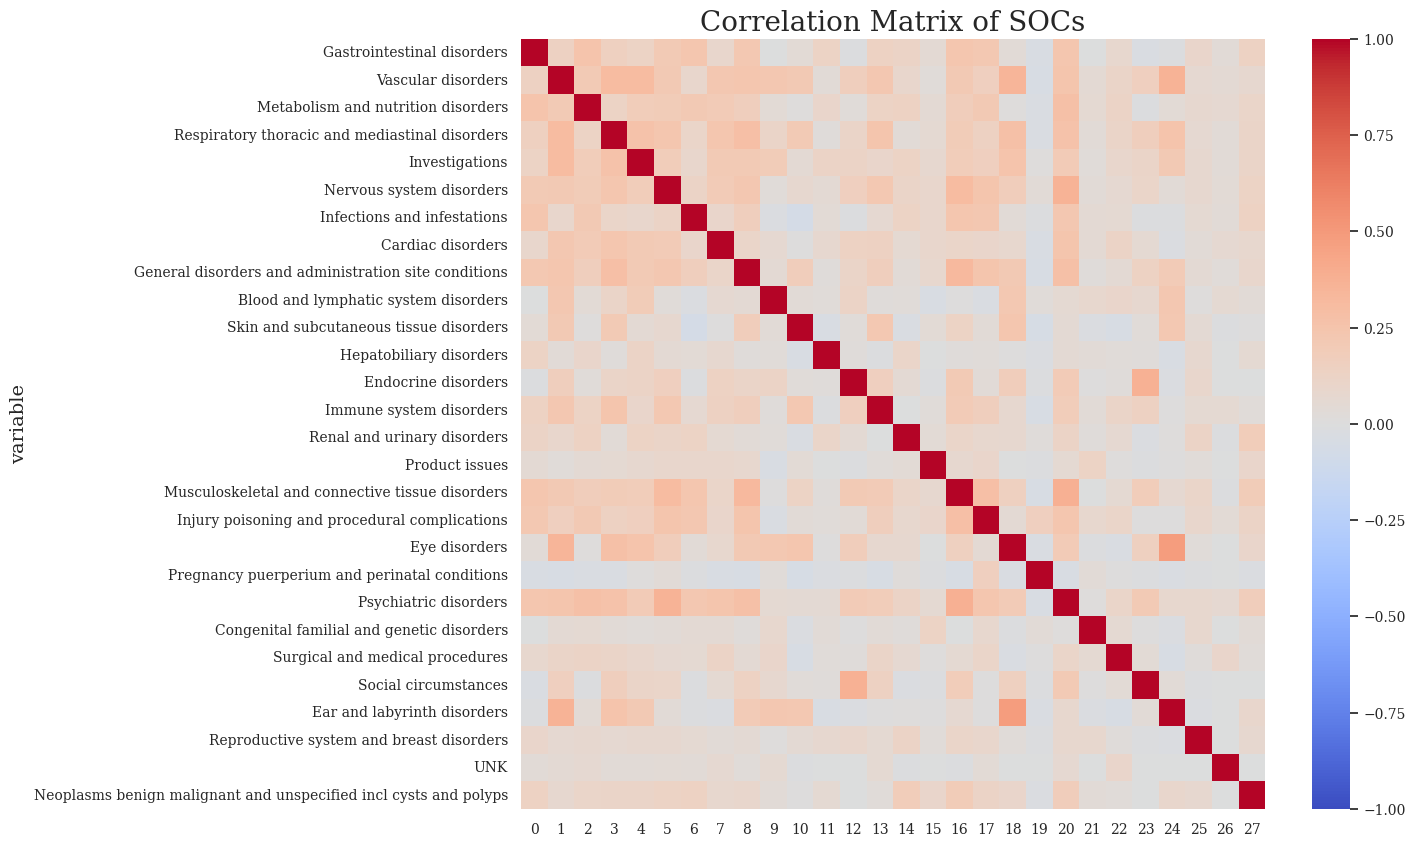

In [38]:
# Clustermap
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
corr = {
    c1: [
        pt_df.select(pl.corr(c1, c2)).item()
        for c2 in event_cols
    ]
    for c1 in event_cols
}
corr_df = pl.DataFrame({
    "variable": list(corr.keys()),
    **{f"{i}": [corr[var][i] for var in corr.keys()] for i in range(len(event_cols))}
})
plt.figure(figsize=(12, 10))
corr_matrix = corr_df.to_pandas().set_index('variable') 
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of SOCs")
plt.show()

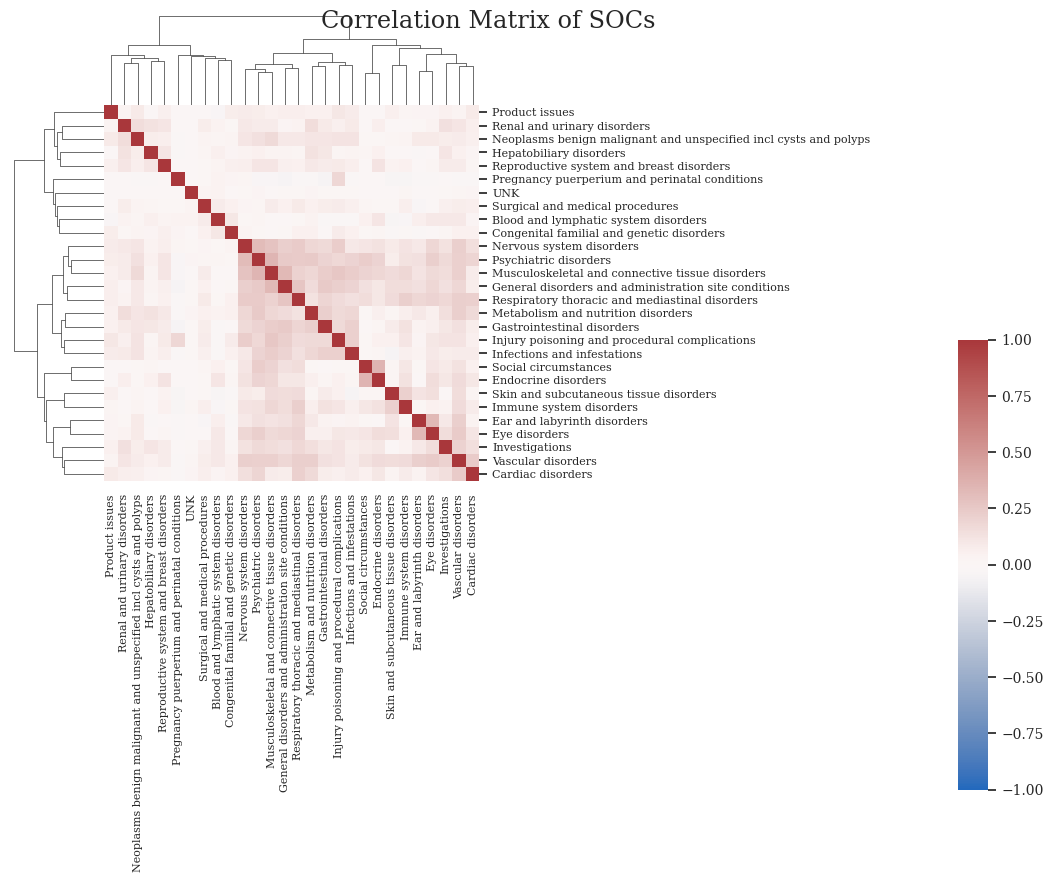

In [62]:
import polars as pl

event_cols = pt_df.columns[1:]

per_report = (
    pt_df
    .group_by("REPORT_ID")
    .agg([pl.max(c).alias(c) for c in event_cols])  # any SOC present in that report
)

import pandas as pd

per_report_pd = per_report.to_pandas()

# index by REPORT_ID, matrix = only event columns
X = per_report_pd.set_index("REPORT_ID")[event_cols]

# correlation between SOCs (phi on 0/1)
corr = X.corr(method="pearson")  # event_cols × even t_cols


# delete the colorbar
g = sns.clustermap(
    corr,
    metric="euclidean",  # distance on the correlation matrix
    method="ward",
    vmin=-1,
    vmax=1,
    cmap="vlag",
)

# g.cax.remove()
# mave the colorbar to the right
g.cax.set_position([.97, .2, .03, .45])

# make the xtick labels smaller
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8)
g.fig.suptitle("Correlation Matrix of SOCs")
plt.savefig('visualizations/canada/soc_correlation_clusters.pdf', bbox_inches='tight')
plt.show()


# SOCS vs SOCs Correlation Matrix

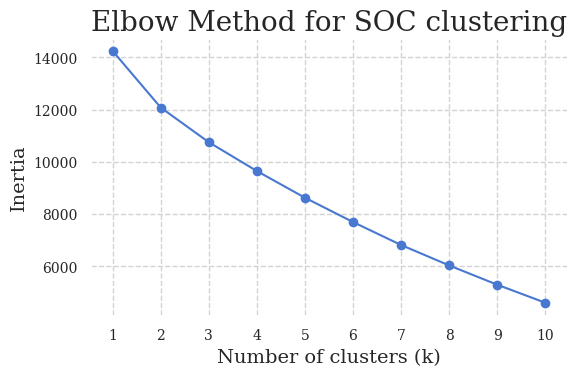

k=2: silhouette (SOCs)=0.299
k=3: silhouette (SOCs)=0.146
k=4: silhouette (SOCs)=0.152
k=5: silhouette (SOCs)=0.154
k=6: silhouette (SOCs)=0.154
k=7: silhouette (SOCs)=0.158
k=8: silhouette (SOCs)=0.153
k=9: silhouette (SOCs)=0.138
k=10: silhouette (SOCs)=0.146
Best k by silhouette: 2


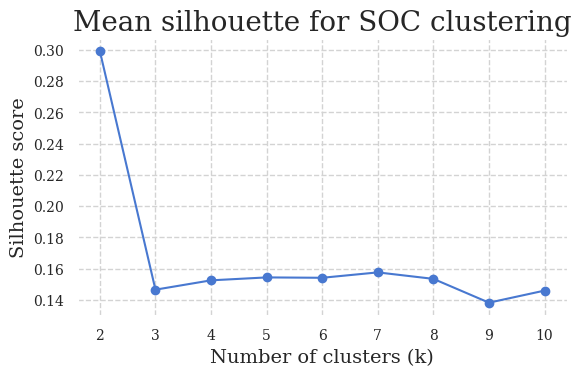

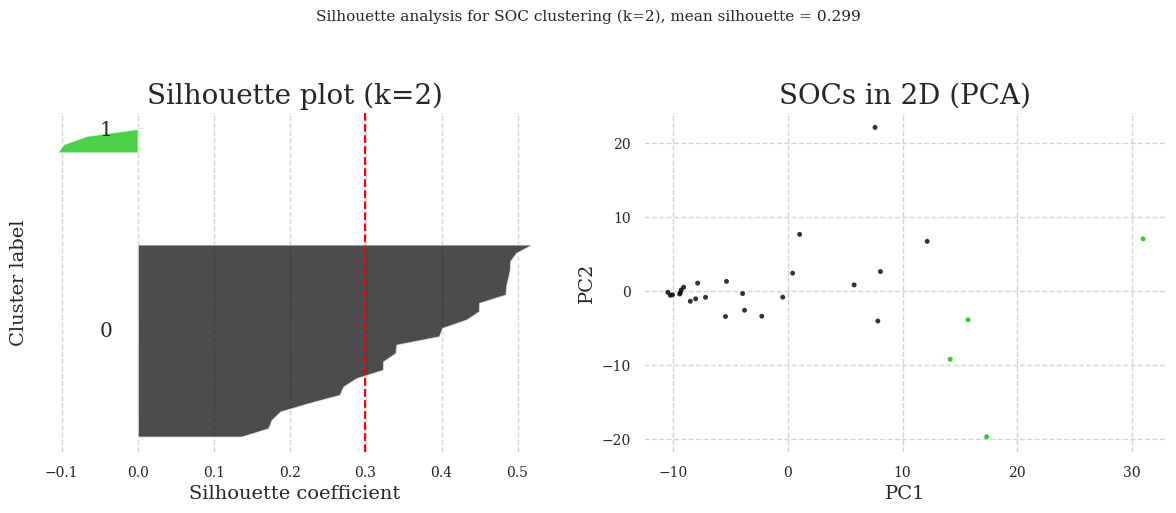

In [59]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ---------- 1. DATA (you already have this) ----------
# X: reports × SOCs
# we are clustering SOCs, so:
X_soc = X.T.values  # shape: n_SOCs × n_reports

# Elbow method (optional)
inertia_soc = []
for k in range(1, 11):
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward"
    )
    labels = model.fit_predict(X_soc)
    # compute inertia as sum of squared distances to cluster centers
    inertia = 0
    for i in range(k):
        cluster_points = X_soc[labels == i]
        if cluster_points.shape[0] > 0:
            center = cluster_points.mean(axis=0)
            inertia += np.sum((cluster_points - center) ** 2)
    inertia_soc.append(inertia)
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), inertia_soc, marker='o')
plt.title("Elbow Method for SOC clustering")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.savefig("visualizations/canada/elbow_soc.pdf", bbox_inches="tight")
plt.show()


# ---------- 2. SCAN k WITH SILHOUETTE ----------
ks = range(2, 11)
sil_scores_soc = []

for k in ks:
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward"
    )
    labels = model.fit_predict(X_soc)
    score = silhouette_score(X_soc, labels, metric="euclidean")
    sil_scores_soc.append(score)

for k, s in zip(ks, sil_scores_soc):
    print(f"k={k}: silhouette (SOCs)={s:.3f}")

best_k = ks[int(np.argmax(sil_scores_soc))]
print("Best k by silhouette:", best_k)

# optional: quick line plot of mean silhouette vs k
plt.figure(figsize=(6, 4))
plt.plot(ks, sil_scores_soc, marker='o')
plt.title("Mean silhouette for SOC clustering")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.xticks(ks)
plt.grid(True)
plt.tight_layout()
plt.savefig("visualizations/canada/silhouette_mean_socs.pdf", bbox_inches="tight")
plt.show()

# ---------- 3. DETAILED SILHOUETTE + PCA SCATTER (1×2) ----------
k = best_k  # or set manually

model = AgglomerativeClustering(
    n_clusters=k,
    linkage="ward"
)
cluster_labels = model.fit_predict(X_soc)

# per-sample silhouette values
sample_silhouette_values = silhouette_samples(
    X_soc,
    cluster_labels,
    metric="euclidean"
)
silhouette_avg = sample_silhouette_values.mean()

# 2D representation of SOCs for visualization
pca = PCA(n_components=2)
X_soc_2d = pca.fit_transform(X_soc)  # shape: n_SOCs × 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ----- left: silhouette plot per SOC -----
y_lower = 10
for i in range(k):
    ith_vals = sample_silhouette_values[cluster_labels == i]
    ith_vals.sort()
    size_i = ith_vals.shape[0]
    y_upper = y_lower + size_i

    color = plt.cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_vals,
        facecolor=color,
        alpha=0.7,
    )

    # label cluster number on the y-axis
    ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10  # space between clusters

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title(f"Silhouette plot (k={k})")
ax1.set_xlabel("Silhouette coefficient")
ax1.set_ylabel("Cluster label")
ax1.set_yticks([])

# ----- right: PCA scatter of SOCs colored by cluster -----
colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / k)
ax2.scatter(
    X_soc_2d[:, 0],
    X_soc_2d[:, 1],
    marker=".",
    s=50,
    lw=0,
    alpha=0.8,
    c=colors,
)
ax2.set_title("SOCs in 2D (PCA)")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.suptitle(
    f"Silhouette analysis for SOC clustering (k={k}), "
    f"mean silhouette = {silhouette_avg:.3f}",
    y=1.03,
    fontsize=11,
)

plt.tight_layout()
# optional save
plt.savefig("visualizations/canada/silhouette_detail_socs.pdf", bbox_inches="tight")
plt.show()


Cluster sizes (SOC-level):
2    24
1     4
Name: count, dtype: int64


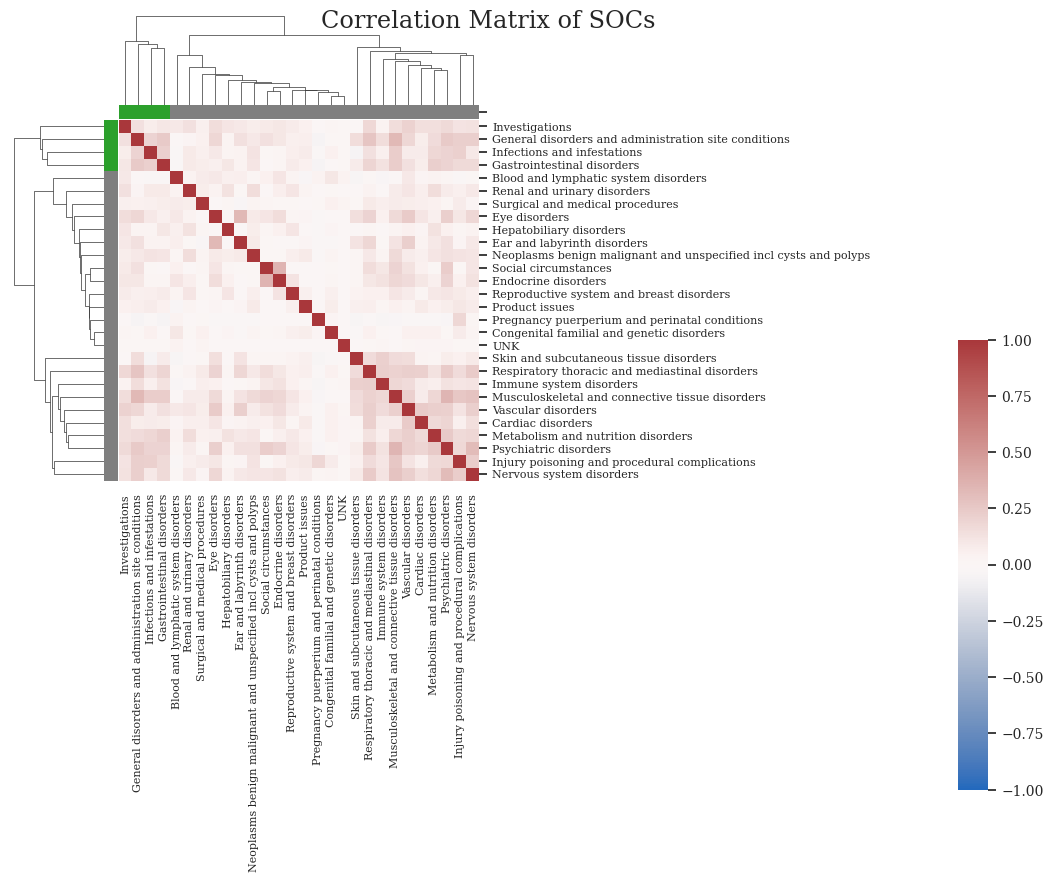

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster

# 1) Same data as silhouette
X_soc = X.T.values           # SOC × reports
soc_names = X.columns.to_list()

# 2) Hierarchical clustering (Ward, Euclidean) on X_soc
Z = linkage(X_soc, method="ward", metric="euclidean")

# 3) Cut into 2 clusters, should match silhouette k=2
labels = fcluster(Z, t=2, criterion="maxclust")
cluster_sizes = pd.Series(labels, index=soc_names).value_counts()
print("Cluster sizes (SOC-level):")
print(cluster_sizes)         # e.g. 4 vs 23

# 4) Build a color strip to see which SOC is in which cluster
palette = {1: "tab:green", 2: "tab:gray"}
row_colors = pd.Series(labels, index=soc_names).map(palette)

# 5) Compute correlation matrix just for the heatmap values
corr = X.corr(method="pearson")

# 6) Clustermap using the SAME linkage as silhouette
g = sns.clustermap(
    corr,
    row_linkage=Z,          # <-- force same tree
    col_linkage=Z,          # symmetric
    row_colors=row_colors,  # color bars by cluster
    col_colors=row_colors,
    cmap="vlag",
    vmin=-1,
    vmax=1
)

g.cax.set_position([.97, .2, .03, .45])
g.fig.suptitle("Correlation Matrix of SOCs")
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8)
plt.savefig('visualizations/canada/soc_correlation_clusters.pdf', bbox_inches='tight')
plt.show()
